In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
#data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,date
0,0,0,-0.000000,2020-01-01
1,0,1,-0.046501,2020-01-02
2,0,2,-0.097796,2020-01-03
3,0,3,-0.144397,2020-01-04
4,0,4,-0.177954,2020-01-05


In [4]:
data['series'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

<AxesSubplot:>

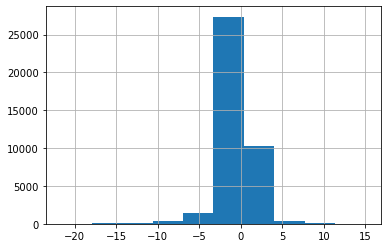

In [5]:
data['value'].hist()

In [6]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [7]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

# Train Model
## Set up pytorch-lightning and params

In [8]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1079: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
Global seed set to 42
Finding best initial lr: 100%|████████████████| 100/100 [00:04<00:00, 22.61it/s]


suggested learning rate: 0.004466835921509632


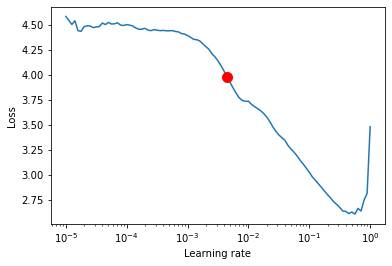

In [9]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

## Fit Model

In [ ]:
# GENERIC Params
params_generic = {
    "stack_types": ["generic"],
    "num_blocks": [1],
    "num_block_layers": [4],
    "widths": [512],
    "sharing": [False],
    "expansion_coefficient_lengths": [32],
    # handled already in the TSDS class (i think)
    # "prediction_length": 10,
    # "context_length": 60,
    # ^ Should be between 1-10 times the prediction length (as per pyf.Nbeats docs)
    # "backcast_loss_ratio": #this the paper doesn't say...so setting as default=0 for now
    # "loss": "MASE",                                    # defaults to MASE(), paper in Generic mode used sMAPE, MAPE as well
    
    ### Base Model params
    #"logging_metrics": ['mse','mape','mae'], #for Tsb   # default looks at [SMAPE(), MAE(), RMSE(), MAPE(), MASE()]
    "optimizer": "adam",                                 # NBEATS uses adam
    "weight_decay": 0,                                   # base model default
    
}

In [ ]:
# net = NBeats.from_dataset(training, **params_generic)

In [10]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  97%|▉| 30/31 [00:01<00:00, 17.79it/s, loss=3.28, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 31/31 [00:01<00:00, 17.06it/s, loss=3.28, v_num=1, train_loss_s
Epoch 1:  97%|▉| 30/31 [00:01<00:00, 18.17it/s, loss=1.86, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:01<00:00, 17.41it/s, loss=1.86, v_num=1, train_loss_s
Epoch 2:  97%|▉| 30/31 [00:01<00:00, 16.94it/s, loss=1.42, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:01<00:00, 16.27it/s, loss=1.42, v_num=1, train_loss_s
Epoch 3:  97%|▉| 30/31 [00:01<00:00, 17.53it/s, loss=1.32, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [0

# Evaluate Results

In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)


In [12]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1831)

In [13]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

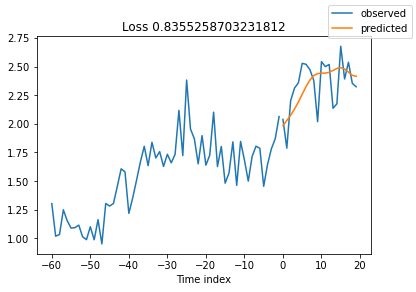

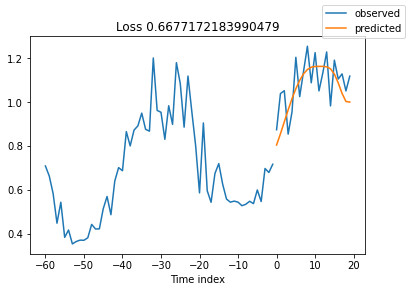

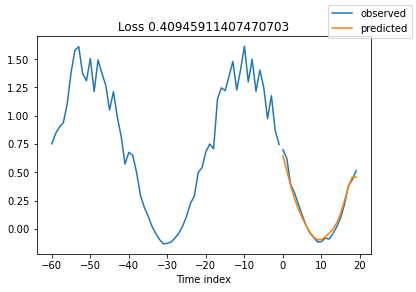

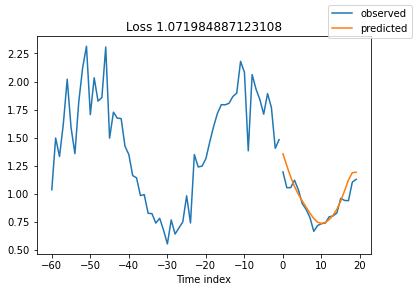

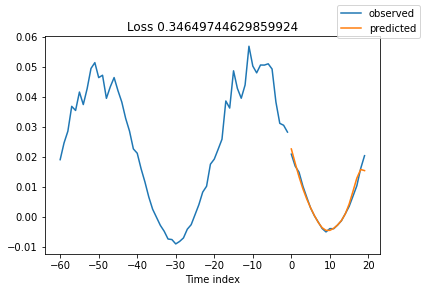

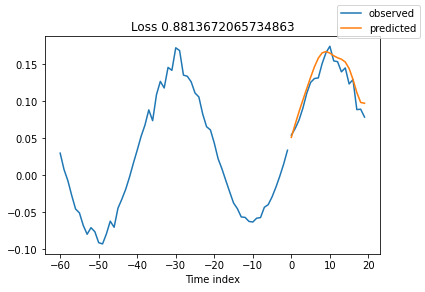

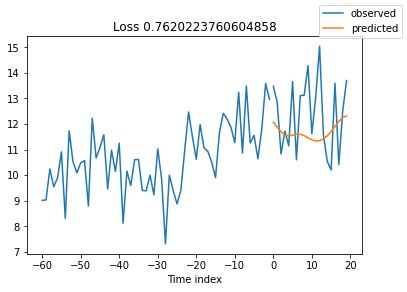

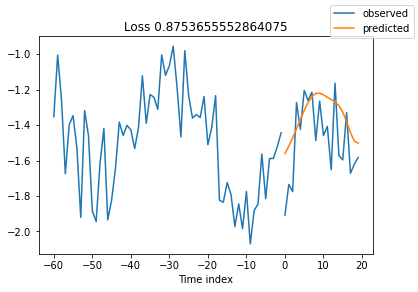

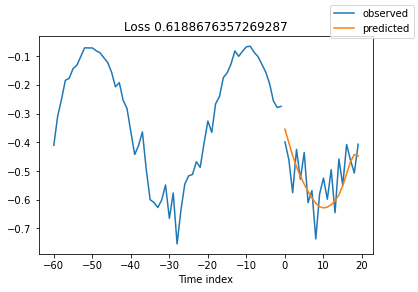

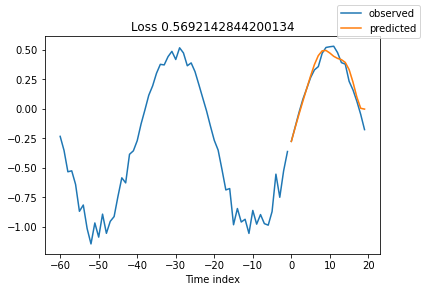

In [14]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);